In [2]:
from numpy.random import seed
seed(1337)

import pandas as pd
import numpy as np


import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Dropout, Flatten, Activation

from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam

import os

from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
batch_size = 30
image_size = (96,96)

In [4]:
root_dir = '.'
train_dir = os.path.join(root_dir,'input','train')
test_dir = os.path.join(root_dir,'input','test')
save_dir = os.path.join(root_dir,'save')

In [5]:
train_input = list(filter(lambda s: s.endswith(".tif"), os.listdir(train_dir)))
test_input = list(filter(lambda s: s.endswith(".tif"), os.listdir(test_dir)))
print("Train input files: {}".format(len(train_input)))
print("Test input files: {}".format(len(test_input)))

Train input files: 220025
Test input files: 57458


In [8]:
df = pd.read_csv("train_labels.csv", dtype=str)
df['path'] = df['id'].apply(lambda s: s+'.tif')
df.head()

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


In [6]:
ratio = df['label'].value_counts()[0]/df['label'].value_counts()[1]

print(df['label'].value_counts(), ratio)

0    130908
1     89117
Name: label, dtype: int64 1.468945319074924


In [9]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df.label)

In [10]:
aug = {'horizontal_flip': True,
       'vertical_flip': True,
       'rotation_range': 90}

datagen = ImageDataGenerator(rescale=1.0/255, **aug)

val_datagen = ImageDataGenerator(rescale=1.0/255)

In [11]:
train_gen=datagen.flow_from_dataframe(dataframe=train_df,
                                      directory=train_dir,
                                      class_mode='binary',
                                      x_col="path",
                                      y_col="label",
                                      subset=None,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      target_size=image_size)

Found 176020 images belonging to 2 classes.


In [12]:
val_gen=val_datagen.flow_from_dataframe(dataframe=val_df,
                                        directory=train_dir,
                                        class_mode='binary',
                                        x_col="path",
                                        y_col="label",
                                        subset=None,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        target_size=image_size)

Found 44005 images belonging to 2 classes.


In [13]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_gen=test_datagen.flow_from_dataframe(dataframe=val_df,
                                          directory=train_dir,
                                          class_mode='binary',
                                          x_col="path",
                                          y_col="label",
                                          batch_size=65,
                                          shuffle=False,
                                          target_size=image_size)

Found 44005 images belonging to 2 classes.


In [88]:
filters = {'CONV1': 32, 'CONV2': 64}
kernel_size = (3, 3)
pool_size = (2, 2)

inputs = Input(shape=(*image_size,3))
x = Conv2D(filters=filters['CONV1'], kernel_size=kernel_size, 
           activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(0.3)(x)

x = Conv2D(filters=filters['CONV2'], kernel_size=kernel_size, 
           activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(0.3)(x)

x = Flatten()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 24, 24, 64)        0         
__________

In [14]:
def auc_metric(ytrue, ypred):
    auc = tf.metrics.auc(ytrue, ypred)[1]
    keras.backend.get_session().run(tf.local_variables_initializer())
    return auc

def steps_from_gen(generator):
    return np.ceil(generator.n//generator.batch_size)

In [89]:
optimizer = Adam(0.001)
model.compile(optimizer, loss = "binary_crossentropy", metrics=["accuracy", auc_metric])

In [64]:
save_file = os.path.join(save_dir, 'model6-{epoch:02d}-{val_acc:.3f}-{val_auc_metric:.3f}.h5')
print(ratio)

1.468945319074924


In [15]:
model = load_model(max([os.path.join(save_dir,f) for f in os.listdir(save_dir)],
                       key=os.path.getctime), custom_objects={'auc_metric': auc_metric})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.


In [15]:
model = load_model(os.path.join(save_dir,'best.h5'), custom_objects={'auc_metric': auc_metric})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.


In [17]:
train_step = steps_from_gen(train_gen)
val_step = steps_from_gen(val_gen)

#class_weight = {0: 1., 1: np.around(ratio, decimals=1)}
class_weight = {0: 1., 1: 1.2}

save_file = os.path.join(save_dir, 'model6-{epoch:02d}-{val_acc:.3f}-{val_auc_metric:.3f}.h5')

check_for_save = False

if check_for_save and os.isfile(save_file):
    model = load_model(save_file, custom_objects={'auc_metric': auc_metric})

#callbacks
ES = EarlyStopping(monitor='val_loss',
                   min_delta=0.0001,
                   patience=2,
                   verbose=2,
                   mode='min')

TB = TensorBoard(log_dir='./logs',
                 write_graph=True,
                 histogram_freq=0,
                 update_freq=10000)

MC = ModelCheckpoint(filepath=save_file,
                     monitor='val_loss',
                     mode='min',
                     save_best_only=True,
                     verbose=1)

RL = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)


callbacks = [ES,TB,MC] #,RL]

history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=train_step,
                    validation_data=val_gen,
                    validation_steps=val_step,
                    class_weight = class_weight,
                    #initial_epoch=0,
                    epochs=20,
                    verbose=1,
                    callbacks=callbacks)


Epoch 1/20
5867/5867 [==============================] - 4268s 727ms/step - loss: 0.3642 - acc: 0.8596 - auc_metric: 0.9300 - val_loss: 0.3111 - val_acc: 0.8715 - val_auc_metric: 0.9304

Epoch 00001: val_loss improved from inf to 0.31112, saving model to ./save/model6-01-0.871-0.930.h5
Epoch 2/20
5867/5867 [==============================] - 4311s 735ms/step - loss: 0.3612 - acc: 0.8600 - auc_metric: 0.9308 - val_loss: 0.3265 - val_acc: 0.8666 - val_auc_metric: 0.9310

Epoch 00002: val_loss did not improve from 0.31112
Epoch 3/20
5867/5867 [==============================] - 4267s 727ms/step - loss: 0.3622 - acc: 0.8602 - auc_metric: 0.9310 - val_loss: 0.3083 - val_acc: 0.8752 - val_auc_metric: 0.9313

Epoch 00003: val_loss improved from 0.31112 to 0.30831, saving model to ./save/model6-03-0.875-0.931.h5
Epoch 4/20
5867/5867 [==============================] - 4245s 724ms/step - loss: 0.3582 - acc: 0.8625 - auc_metric: 0.9316 - val_loss: 0.3227 - val_acc: 0.8717 - val_auc_metric: 0.9318

E

In [19]:
model.save(os.path.join(save_dir, 'best2.h5'))

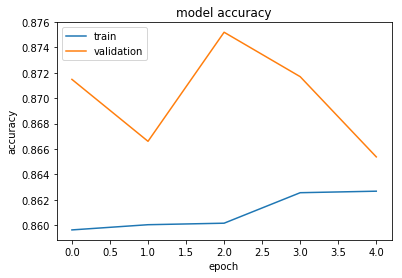

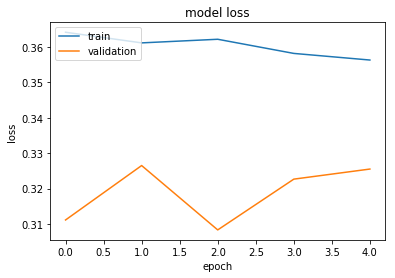

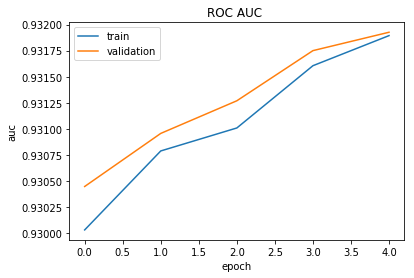

In [20]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['auc_metric'])
plt.plot(history.history['val_auc_metric'])
plt.title('ROC AUC ')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
steps = steps_from_gen(test_gen)
test_gen.reset()

y_preds = model.predict_generator(test_gen,verbose=1,steps=steps, workers=5)

677/677 [==============================] - 375s 553ms/step


In [22]:
labels = test_gen.classes

fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_preds)
auc_keras = auc(fpr_keras, tpr_keras)
print('AUC score :', + auc_keras)

AUC score : 0.9360888771756929


In [51]:
threshold = 0.395
y_pred_binary = np.where(y_preds > threshold, 1, 0)

print(classification_report(labels, y_pred_binary))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     26182
           1       0.84      0.83      0.84     17823

   micro avg       0.87      0.87      0.87     44005
   macro avg       0.86      0.86      0.86     44005
weighted avg       0.87      0.87      0.87     44005



In [52]:
confusion_matrix(labels, y_pred_binary)

array([[23285,  2897],
       [ 2966, 14857]])

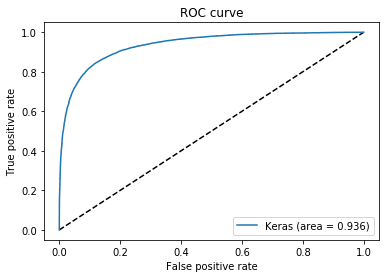

In [53]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [21]:
#model.save(os.path.join(save_dir, 'best.h5'))

In [54]:
test_df = pd.read_csv("sample_submission.csv", dtype=str)
test_df['path']=test_df['id'].apply(lambda s: s+'.tif')

result_gen=ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col="path",
    batch_size=1,
    shuffle=False,
    class_mode=None,
    target_size=image_size)

test_df.head()

Found 57458 images.


,id,label,path
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,0,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf,0,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


In [55]:
result_steps = steps_from_gen(result_gen)
result_gen.reset()

y_test_preds = model.predict_generator(result_gen,verbose=1,steps=result_steps)

57458/57458 [==============================] - 4616s 80ms/step


In [56]:
test_df['label'] = y_test_preds
test_df.head()

,id,label,path
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.072662,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.413565,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.073107,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf,0.160365,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.221408,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


In [57]:
test_df.to_csv("result1.6.csv", columns=('id','label'), index=False, header=True)